In [205]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import pennylane as qml 
from pennylane import numpy as np 
from pennylane import math

import DRU_library
from DRU_library import base_functions as model_dru
from DRU_library import training as model_fit 
from DRU_library import cost_functions
from DRU_library import evaluation as ev

import os
import gc
import json
import time
import subprocess
from openqasm_bridge.v2 import translate

In [206]:
iris = load_iris()
x = iris.data

pca = PCA(n_components=3)
x_pca = pca.fit_transform(x)

scaler = MinMaxScaler(feature_range=(0, np.pi))
X_ = scaler.fit_transform(x_pca)
X_probe =  X_[0:100]


In [207]:
len(X_probe)

100

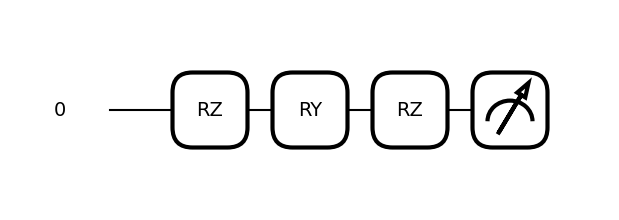

[[1.73038264 2.224712   0.91390419]] [[1.60481225 2.80527559 2.81578778]]


In [208]:
np.random.seed(3)
theta,w = model_dru.parametros(1, capas=1, target_dim=3, qubits=1)
modelo_fidelidad_1 = model_dru.circuito_parametrico(capas = 1, qubits= 1, entrelazamiento='No')
model_dru.dibujar_modelo_completo(modelo_fidelidad_1, X_probe[0], theta, w)
print(theta,w)
#[1.72414847 2.24683366 1.89363699] [1.711801   1.33095081 2.0291362 ]

In [209]:
estados_gate_level = list()

for dato in X_probe:
    estados_gate_level.append(modelo_fidelidad_1(dato, w, theta))




In [210]:
puntos_para_qd =list()

for dato_qd in X_probe: 
    x_0,_ = model_dru.re_dim(dato_qd)
    punto = model_dru.phi_s(x_0, theta, w)[0]
    puntos_para_qd.append(list(punto))
   

In [211]:

compiler_path = "/opt/intel/quantum-sdk/docker-intel_quantum_sdk_1.1.1.2024-11-15T22_03_32+00_00/intel-quantum-compiler"
json_path     = "/opt/intel/quantum-sdk/docker-intel_quantum_sdk_1.1.1.2024-11-15T22_03_32+00_00/intel-quantum-sdk-QDSIM.json"


run_script = os.path.join(os.getcwd(), "run_qd_once.py")

ESTADOS = list()

TEMP_EXT = [".qasm", ".cpp", ".so", ".ll", ".qs"]

i = 0
for theta1, theta2, theta3 in puntos_para_qd:
    name = f"kernel_{i}"
    print(f" datos entrada: ({theta1:.3f}, {theta2:.3f}, {theta3:.3f})")

    
    qasm = f"""
OPENQASM 2.0;
include "qelib1.inc";
qreg q[1];
rz({float(theta1)}) q[0];
ry({float(theta2)}) q[0];
rz({float(theta3)}) q[0];
"""
    with open(name+".qasm","w") as f:
        f.write(qasm)

    
    translated = translate(qasm, kernel_name="my_kernel")
    with open(name+".cpp","w") as f:
        for line in translated:
            f.write(line+"\n")

    
    compile_cmd = [
        compiler_path, "-c", json_path,
        "-p", "trivial", "-S", "greedy",
        "-s", f"{name}.cpp", "-o", f"{name}.so"
    ]
    subprocess.run(compile_cmd, check=True)


    result = subprocess.run(["python3", run_script, name],text=True,capture_output=False)

    result_json = subprocess.run(
        ["python3", run_script, name],
        capture_output=True,
        text=True
    )

    json_line = result_json.stdout.strip().splitlines()[-1]
    data = json.loads(json_line)
    amps = np.array([complex(r,i) for r,i in zip(data["real"], data["imag"])])

    ESTADOS.append(amps)
    print(f"Estado guardado: {amps}")
    for ext in TEMP_EXT:
        try:
            os.remove(name+ext)
        except:
            pass

    gc.collect()
    time.sleep(0.3)
    i += 1

print("\n Fin batch QD_SIM")
print("Total estados:", len(ESTADOS))


 datos entrada: (2.118, 7.517, 4.966)


                       Intel(R) Quantum SDK (V1.1)
Processing source file:
/workspace/fidelidad_medidas/kernel_0.cpp 
-------------------------------------------------------------------------------
Intermediate representation (IR) output file: 
/workspace/fidelidad_medidas/kernel_0.ll
Generating quantum object file...
Compiling and linking to shared object...
Final shared object: 
/workspace/fidelidad_medidas/kernel_0.so
-------------------------------------------------------------------------------

 Ejecutando kernel: kernel_0.so
Tue Oct 28 06:26:32 2025
1761632792 time dependent evolution start time
sweep progress: calculation point=0 0%
sweep progress: calculation point=12598 10%
sweep progress: calculation point=25196 20%
sweep progress: calculation point=37794 30%
sweep progress: calculation point=50392 40%
sweep progress: calculation point=62989 50%
sweep progress: calculation point=75587 60%
sweep progress: calculation point=88185 70%
sweep progress: calculation point=100783 80

In [212]:
densidad = list()
densidad_gate_level = list()

for estado_00 in ESTADOS: 
    densidad_0 = qml.math.outer(estado_00, qml.math.conj(estado_00))
    densidad.append(densidad_0)

for estado_001 in estados_gate_level:
    densidad_01 = qml.math.outer(estado_001, qml.math.conj(estado_001))
    densidad_gate_level.append(densidad_01)


In [213]:
fidelidad_qd = list()

for i in range(len(densidad)):
    fidelidad_0_qd = densidad[i]
    fidelidad_0_dv = densidad_gate_level[i]
    F = qml.math.fidelity(fidelidad_0_dv,fidelidad_0_qd)
    fidelidad_qd.append(F) 

In [214]:
print(f"fidelidad en 150 puntos: {np.mean(fidelidad_qd):.6f} | desviación estándar: {np.std(fidelidad_qd, ddof=1):.6f} | error: {np.std(fidelidad_qd, ddof=1) / np.sqrt(len(fidelidad_qd)):.6f}")


fidelidad en 150 puntos: 0.822255 | desviación estándar: 0.207493 | error: 0.020749
